## **3. Recognizing hand-written digits**
Let's follow the assignment instructions.

In [53]:
import numpy as np 
import pandas as pd
from sklearn.datasets import fetch_openml
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

First we load the dataset and look at the object we loaded.

In [54]:
mnist = fetch_openml('mnist_784')

In [55]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [56]:
X, Y = mnist['data'], mnist['target']
print(f'\nShape of X : {X.shape}')
print(f'Type of X : {type(X)}')
print(f'\nShape of Y : {Y.shape}')
print(f'Type of Y : {type(Y)}')


Shape of X : (70000, 784)
Type of X : <class 'pandas.core.frame.DataFrame'>

Shape of Y : (70000,)
Type of Y : <class 'pandas.core.series.Series'>


Here is a sample from the dataset.

In [57]:
def show_digit(X, Y, id):
    if 'pandas' in str(type(X)):
        sample = np.array(X.iloc[id, :])
    else:
        sample = X[id]
    sample_img = sample.reshape(28,28)

    annot = Y.iloc[id] if 'pandas' in str(type(Y)) else Y[id]
    plt.figure()
    plt.title(f'This is annotated as a {annot}')
    plt.imshow(sample_img, cmap='grey')
    return sample_img

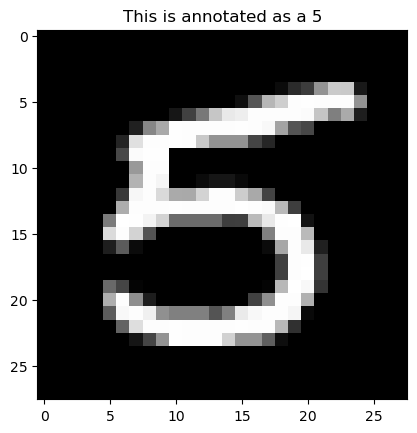

In [58]:
id = rd.sample([i for i in range(X.shape[0])], 1)[0]

sample_img = show_digit(X, Y, id)

We will now define our training and test sets. 

In [59]:
all_set = set([i for i in range(X.shape[0])])
train_set = set(rd.sample(list(all_set), 50000))
val_set = set(rd.sample(list(all_set - train_set), 10000))
test_set = set(rd.sample(list(all_set - train_set - val_set), 10000))

train_list = list(train_set)
val_list = list(val_set)
test_list = list(test_set)


Sanity check on distinction between training, validation and test sets

In [60]:
print(f'\nIntersection between train and validation sets : {train_set.intersection(val_set)}')
print(f'\nIntersection between train and test sets : {train_set.intersection(test_set)}')
print(f'\nIntersection between val and test sets : {val_set.intersection(test_set)}')


Intersection between train and validation sets : set()

Intersection between train and test sets : set()

Intersection between val and test sets : set()


In [61]:
X_train, Y_train = X.iloc[train_list,:], Y.iloc[train_list]
X_val, Y_val = X.iloc[val_list,:], Y.iloc[val_list]
X_test, Y_test = X.iloc[test_list,:], Y.iloc[test_list]

Scaling data will help with future training.

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

First, we will train a binary classifier, able to recognize one digit against all others. Using a 2-layer (20,20) Neural Network.


In [63]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

In [64]:
is_5_train = (Y_train == '5')
is_5_val = (Y_val == '5')

mlp = MLPClassifier(hidden_layer_sizes=(20,20), max_iter=100)
mlp.fit(X_train, is_5_train)

predictions_5 = mlp.predict(X_val)

In [65]:
print(classification_report(is_5_val, predictions_5))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      9139
        True       0.97      0.94      0.95       861

    accuracy                           0.99     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.99      0.99      0.99     10000



Using cross-validation with a 2-layer (10,10) network.

In [66]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=100)

scores = cross_val_score(mlp, X_train, is_5_train, cv=3, scoring='accuracy', n_jobs=-1)
print(scores)

[0.98818024 0.98692026 0.98817953]


We are obtaining really good performances ! However it's important to remember that we simplified a lot the complexity of the task by simply reducing it to predicting fives.

Let's experiment on model architecture and training

### **Experimenting the link between neural network hyperparameters and performances**

#### **Modifying the number of hidden units**

In [67]:
mlp_5 = MLPClassifier(hidden_layer_sizes=(5,5), max_iter=100)
mlp_10 = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=100)
mlp_20 = MLPClassifier(hidden_layer_sizes=(20,20), max_iter=100)
mlp_50 = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=100)
mlp_100 = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=100)

model_list_units = [mlp_5, mlp_10, mlp_20, mlp_50, mlp_100]

def fit_and_val(estimator, X_train, Y_train, X_val, Y_val):
    estimator.fit(X_train, Y_train)

    yhat_train = estimator.predict(X_train)
    perf_train = accuracy_score(Y_train, yhat_train)

    yhat_val = estimator.predict(X_val)
    perf_val = accuracy_score(Y_val, yhat_val)

    return perf_train, perf_val

def experiment(model_list, X_train, Y_train, X_val, Y_val, parameter):
    perf_history = {parameter:[], 'Accuracy':[], 'Set':[]}
    for model in tqdm(model_list):
        if parameter == 'units':
            param = model.get_params()['hidden_layer_sizes'][0]
        elif parameter == 'n_layers':
            param = len(model.get_params()['hidden_layer_sizes'])
        perf_train, perf_val = fit_and_val(model, X_train, Y_train, X_val, Y_val)
        perf_history[parameter].append(param)
        perf_history['Accuracy'].append(perf_train)
        perf_history['Set'].append('train')

        perf_history[parameter].append(param)
        perf_history['Accuracy'].append(perf_val)
        perf_history['Set'].append('validation')
    return pd.DataFrame(perf_history)

def plot_experiment(perf_history):
    sns.lineplot(data=perf_history, x=perf_history.columns[0], y='Accuracy', hue='Set')
    plt.title(f'Performance when changing {perf_history.columns[0]}')
    plt.show()

100%|██████████| 5/5 [10:33<00:00, 126.72s/it]


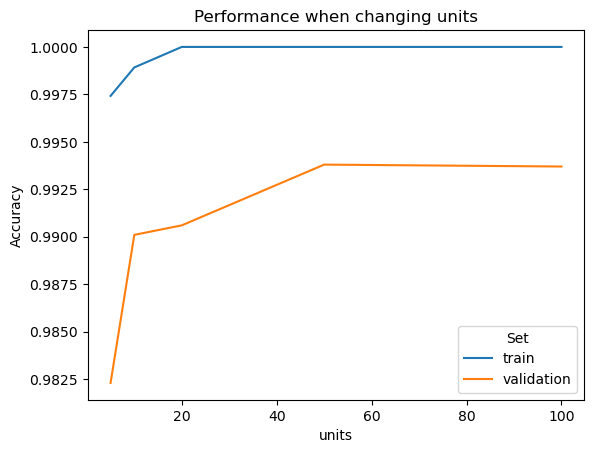

In [68]:
perf_history_units = experiment(model_list_units, X_train, is_5_train, X_val, is_5_val, parameter='units')
plot_experiment(perf_history_units)

At first, increasing the number of units lead to performance increase on both the training and validation set. However, we quickly reach the 100 % accuracy plateau for training but the accuracy for the validation set can still be improved. When we continue to increase the number of units, we see that the performance reached on the validation set seem to hit a plateau which shows that there is a limit to what more hidden units can yield in performance increase. By putting too many units, we are slowing down how quicly the model can be trained while not getting more generalization power out of it.

#### **Modifying the number of layers**

100%|██████████| 6/6 [20:44<00:00, 207.34s/it]


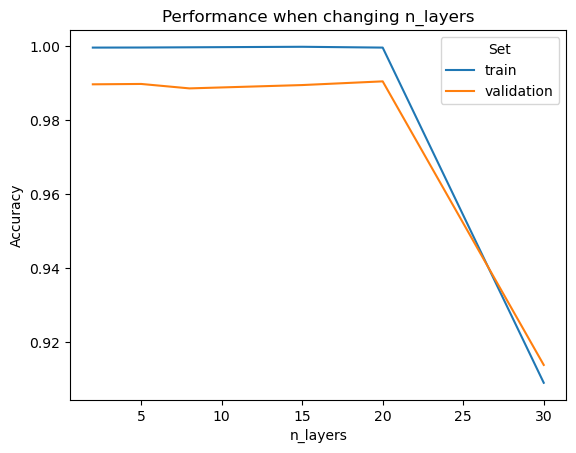

In [69]:
mlp_2L = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=100)
mlp_5L = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10), max_iter=100)
layers_8 = [10 for i in range(8)]
mlp_8L = MLPClassifier(hidden_layer_sizes=tuple(layers_8), max_iter=100)
layers_15 = [10 for i in range(15)]
mlp_15L = MLPClassifier(hidden_layer_sizes=tuple(layers_15), max_iter=100)
layers_20 = [10 for i in range(20)]
mlp_20L = MLPClassifier(hidden_layer_sizes=tuple(layers_20), max_iter=100)
layers_30 = [10 for i in range(30)]
mlp_30L = MLPClassifier(hidden_layer_sizes=tuple(layers_30), max_iter=100)

model_list_layers = [mlp_2L, mlp_5L, mlp_8L, mlp_15L, mlp_20L, mlp_30L]
perf_history_layers = experiment(model_list_layers, X_train, is_5_train, X_val, is_5_val, parameter='n_layers')
plot_experiment(perf_history_layers)

We observe a performance decrease when the number of layers is sufficiently increased ! Here we even see the training curve go below the validation curve. Once again, there is a compromise to be found between enough layers to be able to build a complex enough network and not having to many layers which slows down training and can lead to performance decrease.

One last thing we will look at is how will performances be affected if we change the number of iterations for a given architecture ? We expect that fewer iterations lead to lower accuracy values and that letting the model train longer may help its performances.

In [ ]:
max_iter_list = [1, 2, 20, 200, 500]
acc_list = []
for n_iter in max_iter_list:
    best_mlp = MLPClassifier(hidden_layer_sizes=(5,5), max_iter=n_iter)

    best_mlp.fit(X_train, is_5_train)

    yhat = best_mlp.predict(X_val)

    acc_list.append(accuracy_score(is_5_val, yhat))

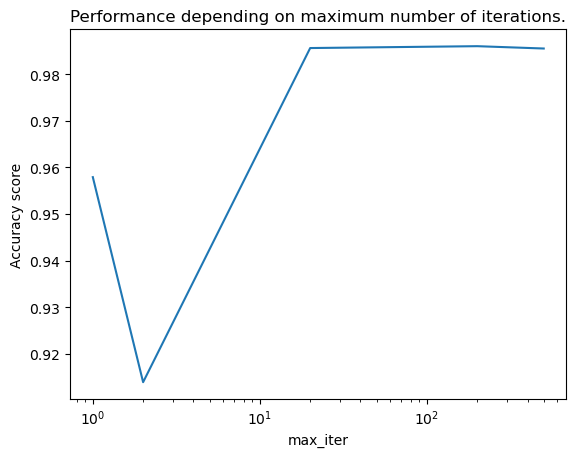

In [79]:
plt.figure()
plt.plot(max_iter_list, acc_list)
plt.xscale('log')
plt.xlabel('max_iter')
plt.ylabel('Accuracy score')
plt.title('Performance depending on maximum number of iterations.')
plt.show()

Once again, letting the model train longer leads at first to performance increases but at some point, longer training stopped leading to gains in performance.

These experiments show why it is important to choose wisely the hyperparameters of both architecture and training when trying to optimize a model.

### **Limitations : Experimenting model performance on rotated images**

We will continue our experiments by exploring the limitations of a model trained earlier. We will do so by exposing it to rotated images.

In [71]:
def rotate(img, theta):
    angle = theta*np.pi/180
    if theta > 0:
        rotation = np.array([np.cos(angle), -np.sin(angle), np.sin(angle), np.cos(angle)]).reshape(2,2)
    else:
        rotation = np.array([np.cos(angle), np.sin(angle), -np.sin(angle), np.cos(angle)]).reshape(2,2)
    img_dim = img.shape
    map_pixel = {}
    for row in range(img_dim[0]):
        for col in range(img_dim[1]):
            pixel_array = np.array([row, col]).reshape(1,-1)
            new_pos = np.dot(pixel_array, rotation)
            new_pos = new_pos.round().astype(int)
            map_pixel[(row, col)] = (new_pos[0,0], new_pos[0,1])

    # translation to keep all coordinates positive
    all_new_coords = np.array(list(map_pixel.values()))
    min_coords = all_new_coords.min(axis=0)
    translation = -min_coords 

    # final image with padding to prevent cropping 
    max_coords = all_new_coords.max(axis=0) + translation
    new_img = np.zeros((max_coords[0] + 1, max_coords[1] + 1))

    for (row, col), (new_x, new_y) in map_pixel.items():
            translated_x = new_x + translation[0]
            translated_y = new_y + translation[1]
            new_img[translated_x, translated_y] = img[row, col]
    
    # crop image to the original dimensions
    start_x = (new_img.shape[0] - img_dim[0]) // 2
    start_y = (new_img.shape[1] - img_dim[1]) // 2
    cropped_img = new_img[start_x:start_x + img_dim[0], start_y:start_y + img_dim[1]]

    return cropped_img

    return new_img

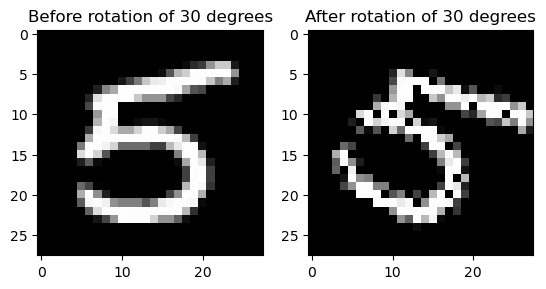

In [72]:
theta = 30
rotated_sample_img = rotate(sample_img, theta)

fig, ax = plt.subplots(1,2)
plt.subplot(1,2,1)
plt.title(f'Before rotation of {theta} degrees')
plt.imshow(sample_img, cmap='grey')
plt.subplot(1,2,2)
plt.title(f'After rotation of {theta} degrees')
plt.imshow(rotated_sample_img, cmap='grey')
plt.show()

Some pixels are disappearing due to the rounding of numbers when computing the rotation. One trick commonly used is to increase the size of the image before rotation and then downscaling it afterwards. The downsize will be a lower resolution in the end.

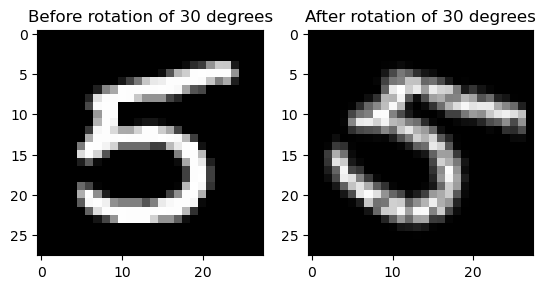

In [73]:
from scipy.ndimage import zoom

def upscale_and_rotate(img, theta, upscale_factor=2):
    # increase size
    upscaled_img = zoom(img, upscale_factor, order=1) 

    rotated_img = rotate(upscaled_img, theta)
    
    # decrease size
    final_img = zoom(rotated_img, 1 / upscale_factor, order=1)
    
    return final_img

rotated_sample_img_better = upscale_and_rotate(sample_img, theta)

fig, ax = plt.subplots(1,2)
plt.subplot(1,2,1)
plt.title(f'Before rotation of {theta} degrees')
plt.imshow(sample_img, cmap='grey')
plt.subplot(1,2,2)
plt.title(f'After rotation of {theta} degrees')
plt.imshow(rotated_sample_img_better, cmap='grey')
plt.show()

In [74]:
def rotate_set(img_set, theta, upscale_factor=2):
    assert 'int' in str(type(upscale_factor)), 'factor must be an integer.'
    if 'pandas' in str(type(img_set)):
        img_set = np.array(img_set)
    
    img = img_set[0, :].reshape(28,28)
    new_img = upscale_and_rotate(img, theta, upscale_factor)
    final_shape = new_img.shape
    new_set = np.zeros((img_set.shape[0],final_shape[0]**2))
    new_set[0,:] = new_img.reshape(1,final_shape[0]**2)

    for i in tqdm(range(1,img_set.shape[0])):
        img = img_set[i, :].reshape(28,28)
        new_img = upscale_and_rotate(img, theta, upscale_factor).reshape(1,final_shape[0]**2)
        new_set[i,:] = new_img
    return new_set


In [75]:
rotated_5_val = rotate_set(X_val, 5)
rotated_10_val = rotate_set(X_val, 10)
rotated_20_val = rotate_set(X_val, 20)

100%|██████████| 9999/9999 [11:17<00:00, 14.77it/s]


In [76]:
rotated_30_val = rotate_set(X_val, 30)

  1%|          | 96/9999 [00:06<10:25, 15.83it/s]

100%|██████████| 9999/9999 [10:56<00:00, 15.24it/s]


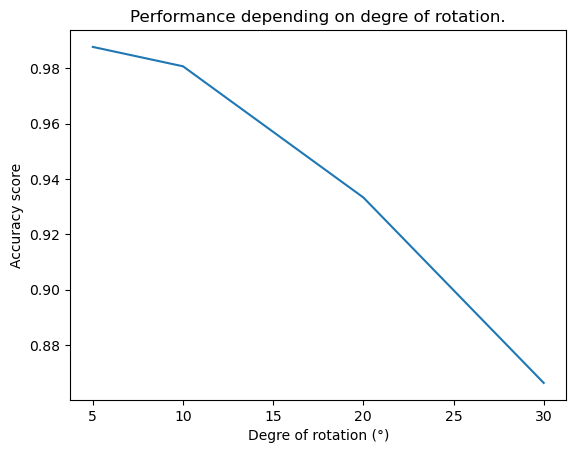

In [77]:
yhat_rotated_5 = mlp_20.predict(rotated_5_val)
acc_5 = accuracy_score(is_5_val, yhat_rotated_5)

yhat_rotated_10 = mlp_20.predict(rotated_10_val)
acc_10 = accuracy_score(is_5_val, yhat_rotated_10)

yhat_rotated_20 = mlp_20.predict(rotated_20_val)
acc_20 = accuracy_score(is_5_val, yhat_rotated_20)

yhat_rotated_30 = mlp_20.predict(rotated_30_val)
acc_30 = accuracy_score(is_5_val, yhat_rotated_30)

plt.plot([5,10,20,30], [acc_5, acc_10, acc_20, acc_30])
plt.title('Performance depending on degre of rotation.')
plt.xlabel('Degre of rotation (°)')
plt.ylabel('Accuracy score')
plt.show()

We see that the more rotation is applied to images, the more the model performs badly !  

This shows the importance of training data when building a model for a task. If we want the neural network to learn how to recognize fives despite of rotation, we need to train the model accordingly by introducing a variety of rotated images at different degrees in the training set.